In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ

import ramsey_experiment

# Loading your IBM Quantum account(s)
IBMQ.save_account(os.environ.get('IBM_KEY'), overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')



ibmqfactory.load_account:WARNING:2024-01-11 16:30:21,046: Credentials are already in use. The existing account in the session will be replaced.


In [67]:
import Ramsey_ExperimentV2
import random
import importlib
from tqdm import tqdm

ramsey_experiment = importlib.reload(Ramsey_ExperimentV2)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[(i + 1) % n] - 1) for i in range(n - 1)])
y_lornz = lambda a, x, w: np.pi*(2 * a / (a ** 2 + (x - w) ** 2) + 2 * a / (a ** 2 + (x + w) ** 2))
y_lornz_single = lambda a, x, w: (2 * a / ((a ** 2 + x ** 2)*2*np.pi))

def sinc(x_values):
    X = []
    for x in x_values:
        X.append((np.sin(2*x * np.pi) / (2*x * np.pi) if x != 0 else 1))
    return X

def effective_hem(size, J, W):
    hem = np.zeros((2 ** size, 2 ** size))
    for i in range(2 ** size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1) ** int(i) for i in binary]
        #Z.reverse()
        hem[i, i] = h(size, J, Z)
        hem[i, i] += sum([W[k] for k in range(size) if binary[k] == '1'])
    return hem

J =  [4.3351257760180895, 3.7487088205694485, 2.6155543721314474, 1.46281652433348]
W =  [3, 3, 3, 3, 3]


Creating experiments:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)
Creating experiments:  99%|█████████▉| 99/100 [00:59<00:00,  1.63it/s]C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)
Creating experiments: 100%|██████████| 100/100 [03:34<00:00,  2.14s/it]


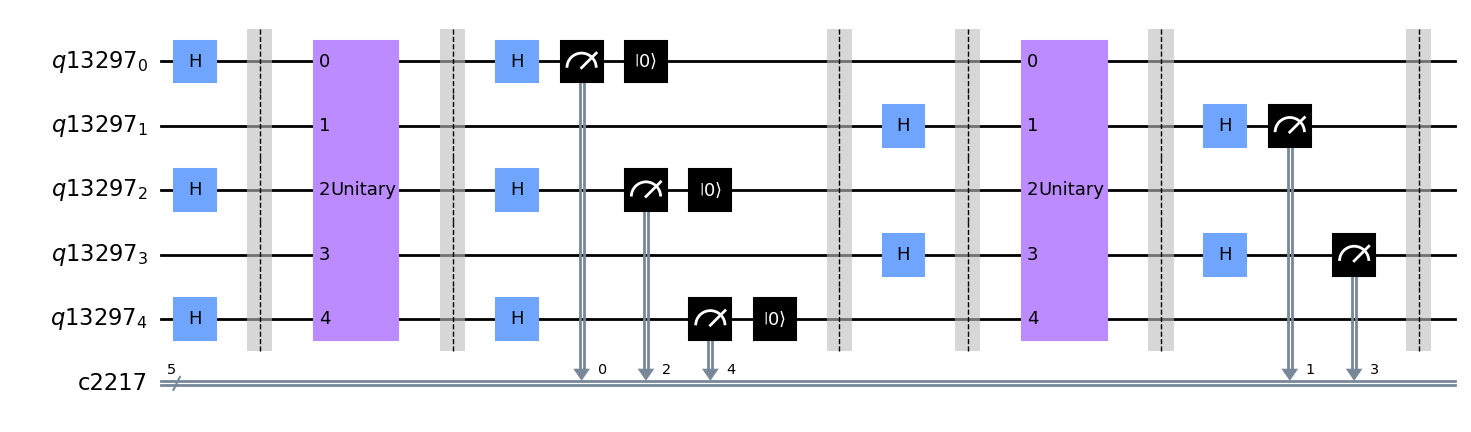

In [68]:


n = 5
T = 3*np.pi

W = [random.gauss(3, 1) for _ in range(n)]
L = [random.gauss(1, 1) for _ in range(n)]
J = [random.gauss(3, 1) for _ in range(n - 1)]

L = [0, 0.1, 0.5, 1, 2]
#L = [0.5]

W = [3, 3, 3, 3, 3]
#W = [3]
#J = [3,5,7,9]
# W = [3]
# L = [3]

shots = 1000

print("J = ", J)
print("W = ", W)

batch1 = []
batch2 = []

exp = []
measurements = 100
delay = np.linspace(0, T, measurements)
for t in tqdm(delay, desc='Creating experiments'):
    exp = RamseyExperiment(n, t, shots, J, W, L)
    exp.create_circuit_detuning()
    exp.add_decay_raw()
    #exp.add_noise_raw()
    batch1.append(exp)

    exp = RamseyExperiment(n, t, shots, J, W, L)
    exp.create_circuit_detuning()
    exp.add_decay()
    exp.add_noise()
    batch2.append(exp)

    #print(t)
ramseyBatch1 = RamseyBatch(batch1)
ramseyBatch2 = RamseyBatch(batch2)
batch2[1].circuit.draw(output='mpl')  # 'mpl' for matplotlib drawing

#print(effective_hem(3,J,W))

In [74]:
print(ramseyBatch1.RamseyExperiments[99].get_counts_from_raw())
print(ramseyBatch1.RamseyExperiments[70].W)
print("delay last = ", delay[-1])
print(effective_hem(ramseyBatch1.RamseyExperiments[70].n, ramseyBatch1.RamseyExperiments[70].J,
                    ramseyBatch1.RamseyExperiments[70].W))

{'11000': 387, '10000': 606, '10100': 4, '11100': 3}
[3, 3, 3, 3, 3]
delay last =  9.42477796076938
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          3.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          3.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 28.31348359  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         43.30831887
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  63.64882197]]


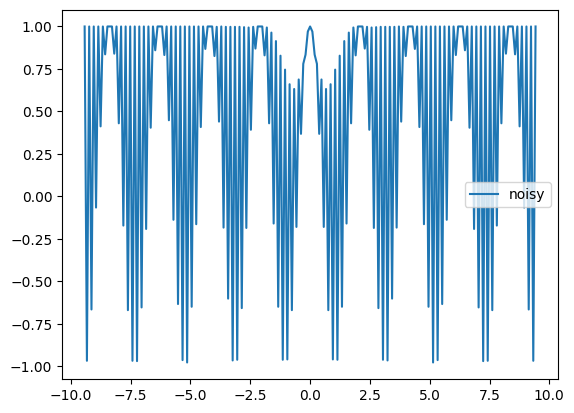

In [75]:
from scipy.ndimage import gaussian_filter
from scipy import signal
k = 0


def apply_lowpass_filter(data, cutoff=4, fs=1, size=200):
    def design_lowpass_filter(cutoff, fs, numtaps):
        nyquist = 0.5 * fs
        normalized_cutoff = cutoff / nyquist
        return signal.firwin(numtaps, normalized_cutoff)

    filter_coefficients = design_lowpass_filter(cutoff, measurements/T, size)
    return np.convolve(data, filter_coefficients, mode='same')


ext_delay = np.concatenate((delay[::-1]*-1, delay))
ext_signal = ramseyBatch1.get_zi(k)[::-1] + ramseyBatch1.get_zi(k)
#plt.xlim(0, 3*np.pi)
#plt.semilogy(delay,y)
filtered_signal = apply_lowpass_filter(ext_signal)


#plt.plot(delay_ext,y_smooth, label='smoothed')
plt.plot(ext_delay,ext_signal, label='noisy')
#plt.plot(ext_delay,filtered_signal, label='filter')



plt.legend()
#plt.plot(delay,y_smooth)

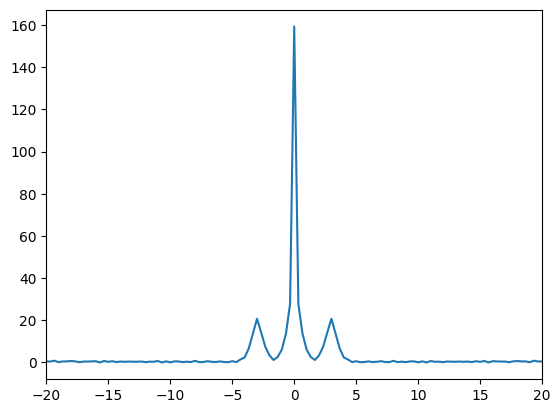

In [46]:
fft_output = np.fft.fft(filtered_signal)
sample_rate = len(delay) / delay[-1]
frequencies = np.fft.fftfreq(len(ext_signal), 1 / sample_rate)
frequencies *= (2 * np.pi)

paired = sorted(zip(frequencies, fft_output))
frequencies, fft_output = zip(*paired)
plt.xlim([-20,20])
plt.plot(frequencies, np.abs(fft_output))

C:\Users\user\AppData\Local\Temp\ipykernel_6556\3475842796.py:8: RuntimeWarning: invalid value encountered in sqrt
  -np.sqrt(
C:\Users\user\AppData\Local\Temp\ipykernel_6556\3475842796.py:10: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(


{'gamma': 2.7649845331429885e-12, 'w0': 1.4199175951240666e-12}
found J =  -2.9999999999985802


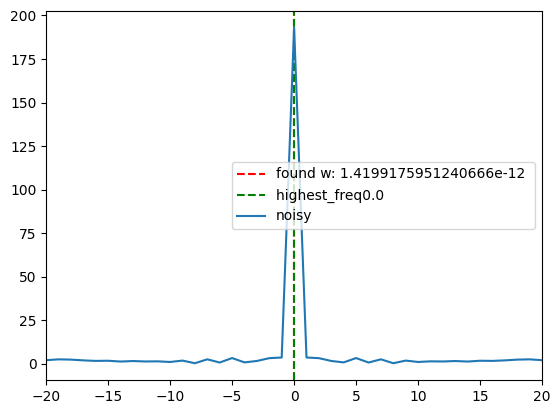

In [39]:
#%matplotlib notebook
k = 0
a = L[k]
frequencies, amplitudes = ramseyBatch1.fft(filter=False)
amplitudes = amplitudes[k]
highest_freq = np.abs(frequencies[np.argmax(amplitudes)])
w_solutions = [
    -np.sqrt(
        -a ** 2 / 3 + highest_freq ** 2 / 3 - 2 * np.sqrt(a ** 4 + a ** 2 * highest_freq ** 2 + highest_freq ** 4) / 3),
    np.sqrt(
        -a ** 2 / 3 + highest_freq ** 2 / 3 - 2 * np.sqrt(a ** 4 + a ** 2 * highest_freq ** 2 + highest_freq ** 4) / 3),
    -np.sqrt(
        -a ** 2 / 3 + highest_freq ** 2 / 3 + 2 * np.sqrt(a ** 4 + a ** 2 * highest_freq ** 2 + highest_freq ** 4) / 3),
    np.sqrt(-(a ** 2) / 3 + (highest_freq ** 2) / 3 + 2 * np.sqrt(
        a ** 4 + (a ** 2) * highest_freq ** 2 + highest_freq ** 4) / 3)
]

#plt.plot(frequencies_ext_sorted, Y1, label='lorenzian',color='red')
#plt.plot(frequencies_ext_sorted, Y2)
#plt.plot(frequencies_ext_sorted, np.abs(Y), label='theory',color='red')

parameters = ramseyBatch1.cauchy_log_likelihood(k)
print(parameters)
print("found J = ", parameters['w0'] - W[k])
#print("J = ", J[k])
plt.axvline(x=parameters['w0'], color='red', linestyle='--', label=f'found w: {parameters["w0"]} ')
plt.axvline(x=highest_freq, color='green', linestyle='--', label=f'highest_freq{highest_freq} ')
plt.plot(frequencies, amplitudes, label='noisy')
plt.xlim([-20,20])
plt.legend()
plt.show()

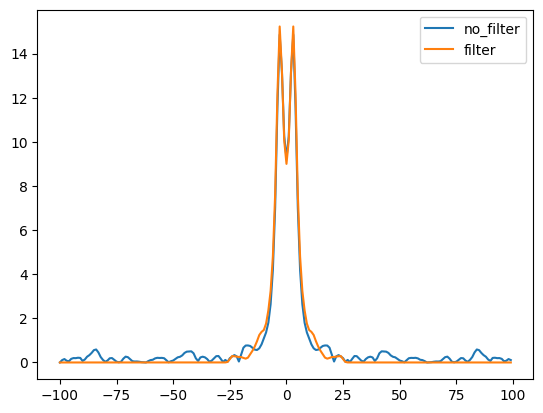

In [247]:
k = 2
a = L[k]
ramseyBatch1.fft()
frequencies = ramseyBatch1.frequencies
amplitudes1 = ramseyBatch1.fft_data[k]
#frequencies, amplitudes= ramseyBatch2.fft()

ramseyBatch2.fft(filter=True)
amplitudes2 = ramseyBatch2.fft_data[k]
plt.plot(frequencies, amplitudes1, label='no_filter')
plt.plot(frequencies, amplitudes2, label='filter')

#plt.xlim([-20,20])
plt.legend()
plt.show()

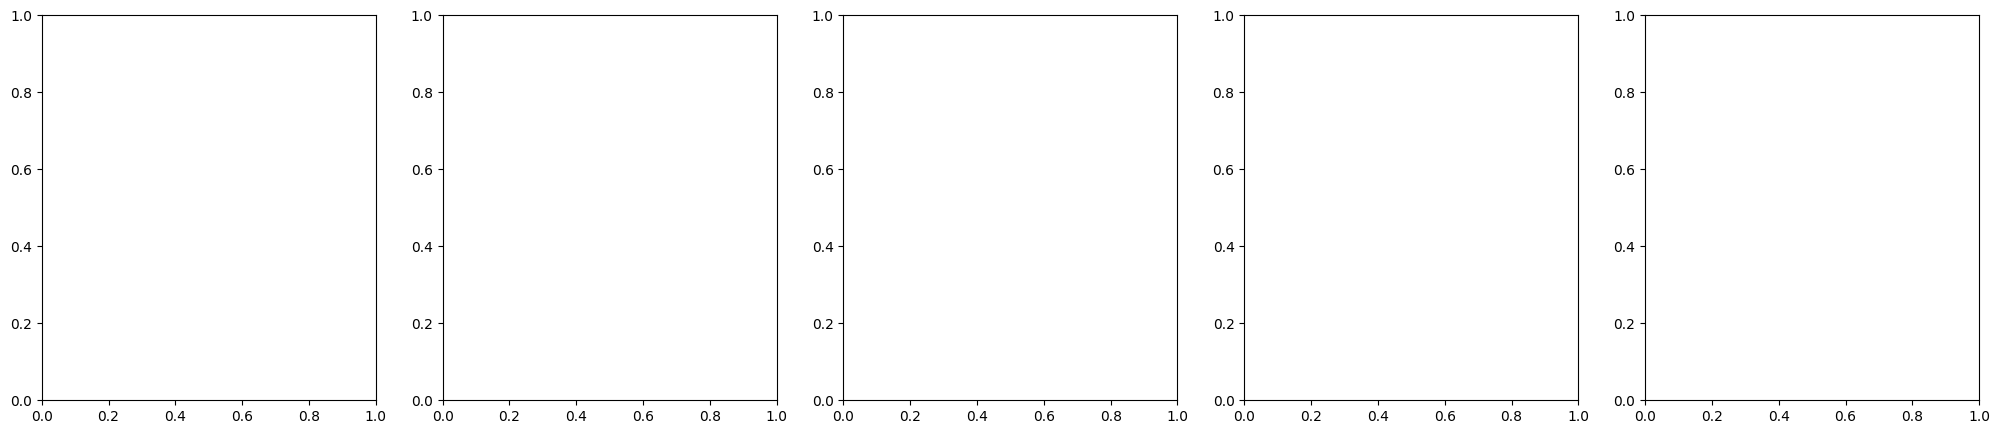

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Set the range for k

# Create subplots
fig, axs = plt.subplots(1, n, figsize=(5 * n, 5))  # Adjust figsize as needed

# Iterate over each k


In [9]:
from sympy import symbols, integrate, oo, pi, Abs
a, x, w = symbols('a x w')
f = x * pi * (2 * a / (a**2 + (x - w)**2) + 2 * a / (a**2 + (x + w)**2))
mu = integrate(f, (x, 0, oo))
mu.simplify
print(mu)

-(pi*a - I*pi*w)*log((-pi*a**2 + 2*a*(pi*a - I*pi*w) - pi*w**2)/pi) - (pi*a + I*pi*w)*log((-pi*a**2 + 2*a*(pi*a + I*pi*w) - pi*w**2)/pi) + oo*sign(a)


In [10]:
from sympy import symbols, diff, solve
a, x, w = symbols('a x w')

y_lornz_single = lambda a, x: (a / ((a ** 2 + x ** 2)*np.pi))
X = np.linspace(-100,100,1000)
Y1 = y_lornz_single(3, X)

def m_l_fun(a, y):
    s = 0
    for i in range(len(y)):
        s += (y[i]**2-a**2)/(y[i]**2 + a**2)
    return s
m_l = m_l_fun(a, Y1)

solution = solve(m_l, a)
print(solution)

# print(np.sum(Y1))
# sum = np.sum(Y1)





KeyboardInterrupt



In [97]:
from scipy.optimize import minimize
k = 3
fft_data = gaussian_filter(ramseyBatch2.fft_data[k], sigma=0)
probs = fft_data / np.sum(fft_data)
samples = np.random.choice(ramseyBatch2.frequencies, size=10000, p=probs)
def cauchy_log_likelihood(data):
    def neg_log_likelihood(params):
        gamma, w = np.abs(params[0]), params[1]  # Ensure gamma is positive
        gamma = np.abs(gamma)  # Ensure gamma is positive
        log_likelihood = np.sum(0.001*np.log(np.pi*(2 * gamma / (gamma ** 2 + (data - w) ** 2) + 2 * gamma / (gamma ** 2 + (data + w) ** 2))))
        return -log_likelihood  # Negative because we minimize

    # Initial guess for gamma using median absolute deviation
    initial_params = [5,5]

    # Optimize using a different method (e.g., 'Nelder-Mead')
    result = minimize(neg_log_likelihood, initial_params, method='Powell')
    gammas = np.linspace(0, 10, 100)
    #plt.plot(gammas, [neg_log_likelihood(gamma) for gamma in gammas])
    if result.success:
        return result.x  # The optimal gamma value
    else:
        raise ValueError("Optimization did not converge: " + result.message)

# Example usage
data = samples
gamma, w0 = cauchy_log_likelihood(data)
print("Estimated gamma:", gamma)
print("Estimated w:", w0)

Estimated gamma: 2.84162288676424
Estimated w: 11.251753542017436


In [ ]:
plt.plot(frequencies, ramseyBatch2.fft_data[1])
plt.xlim([-20,20])
plt.legend()
plt.show()